<a href="https://colab.research.google.com/github/katL7/GTSRB-APS360/blob/main/project_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# Download triffic sign data
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from google.colab import drive
import os
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay


import pandas as pd
import seaborn as sns
%matplotlib inline
# # Importing Data file
# data = pd.read_csv('bc2.csv')
# dataset = pd.DataFrame(data)
# dataset.columns

# Import data

In [14]:
gtsrb_data_train = datasets.GTSRB('data', download=True, split = "train")
gtsrb_data_test = datasets.GTSRB('data', download=True, split = "test")

  0%|          | 0/88978620 [00:00<?, ?it/s]

Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


  0%|          | 0/99620 [00:00<?, ?it/s]

Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb


Figuring out the structure of the dataset

## Labels

In [15]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualisation

In [19]:
print('Len of the train dataset : ', len(gtsrb_data_train))
print('Len of the test dataset : ', len(gtsrb_data_test))

Len of the train dataset :  26640
Len of the test dataset :  12630


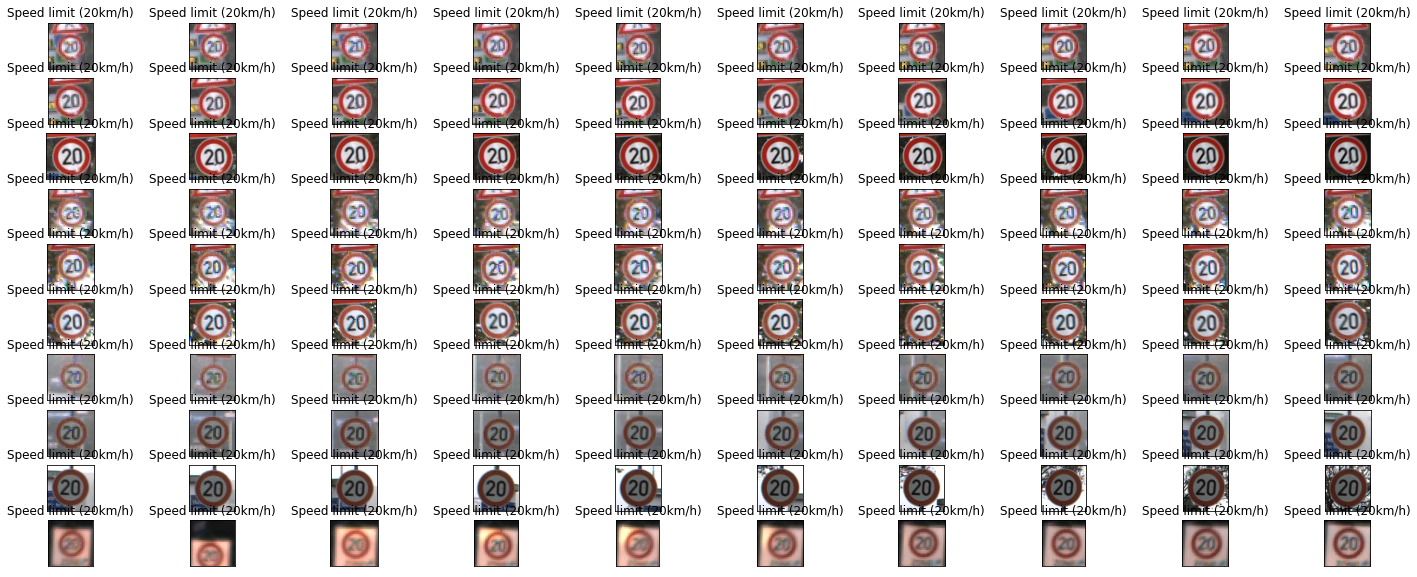

In [17]:
# plot the images with the corresponding labels

fig = plt.figure(figsize=(25, 10))
for idx in np.arange(100):
    ax = fig.add_subplot(10, 20/2, idx+1, xticks=[], yticks=[])

    plt.imshow(gtsrb_data_train[idx][0])
    ax.set_title(classes[gtsrb_data_train[idx][1]])

plt.show()

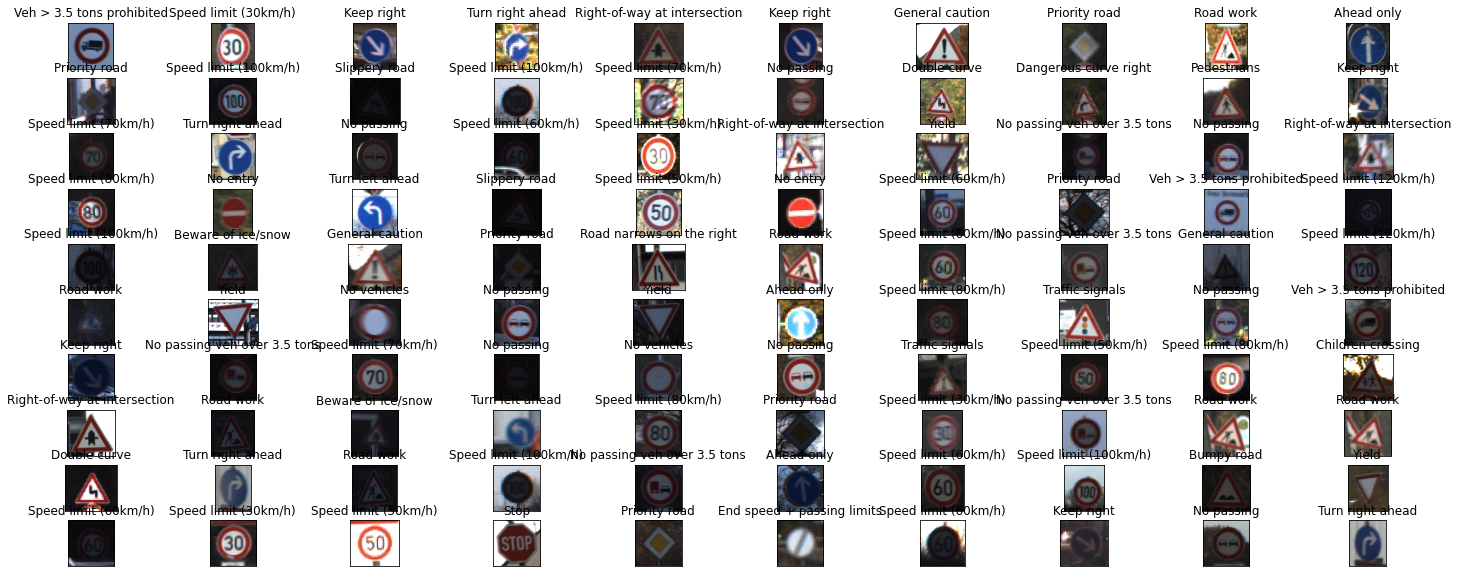

In [18]:
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(100):
    ax = fig.add_subplot(10, 20/2, idx+1, xticks=[], yticks=[])

    plt.imshow(gtsrb_data_test[idx][0])
    ax.set_title(classes[gtsrb_data_test[idx][1]])

plt.show()

In [29]:
ls_id_train = []
ls_classes_train = []
ls_height_train = []
ls_width_train = []
ls_images_train = []


for i in range(len(gtsrb_data_train)):
  ls_id_train.append(i)
  img, l = gtsrb_data_train[i]
  ls_classes_train.append(l)
  ls_height_train.append(img.size[0])
  ls_width_train.append(img.size[1])
  ls_images_train.append(np.array(img))

pd_gtsrb_train = pd.DataFrame(np.array([ls_id_train, ls_classes_train, ls_height_train, ls_width_train]).T,
                   columns=['ID', 'Classe Nb', 'Height', 'Width'])


ls_id_test = []
ls_classes_test = []
ls_height_test = []
ls_width_test = []
ls_images_test = []


for i in range(len(gtsrb_data_test)):
  ls_id_test.append(i)
  img, l = gtsrb_data_test[i]
  ls_classes_test.append(l)
  ls_height_test.append(img.size[0])
  ls_width_test.append(img.size[1])
  ls_images_test.append(np.array(img))

pd_gtsrb_test = pd.DataFrame(np.array([ls_id_test, ls_classes_test, ls_height_test, ls_width_test]).T,
                   columns=['ID', 'Classe Nb', 'Height', 'Width'])






pd_gtsrb_train.head(10)

,ID,Classe Nb,Height,Width
0,0,0,29,30
1,1,0,30,30
2,2,0,30,30
3,3,0,31,31
4,4,0,30,32
5,5,0,31,31
6,6,0,33,34
7,7,0,34,35
8,8,0,33,34
9,9,0,36,36


In [30]:
pd_gtsrb_train[['Classe Nb',	'Height',	'Width']].describe()

,Classe Nb,Height,Width
count,26640.000000,26640.000000,26640.000000
mean,15.887387,50.933784,50.365128
std,12.044099,24.373418,23.161523
min,0.000000,25.000000,25.000000
25%,5.000000,35.000000,35.000000
50%,12.000000,43.000000,43.000000
75%,25.000000,58.000000,58.000000
max,42.000000,243.000000,225.000000


In [31]:
pd_gtsrb_test[['Classe Nb',	'Height',	'Width']].describe()

,Classe Nb,Height,Width
count,12630.000000,12630.000000,12630.000000
mean,15.551069,50.507759,50.364450
std,11.947123,25.088483,23.698908
min,0.000000,25.000000,25.000000
25%,5.000000,34.000000,35.000000
50%,12.000000,43.000000,43.000000
75%,25.000000,58.000000,57.000000
max,42.000000,266.000000,232.000000


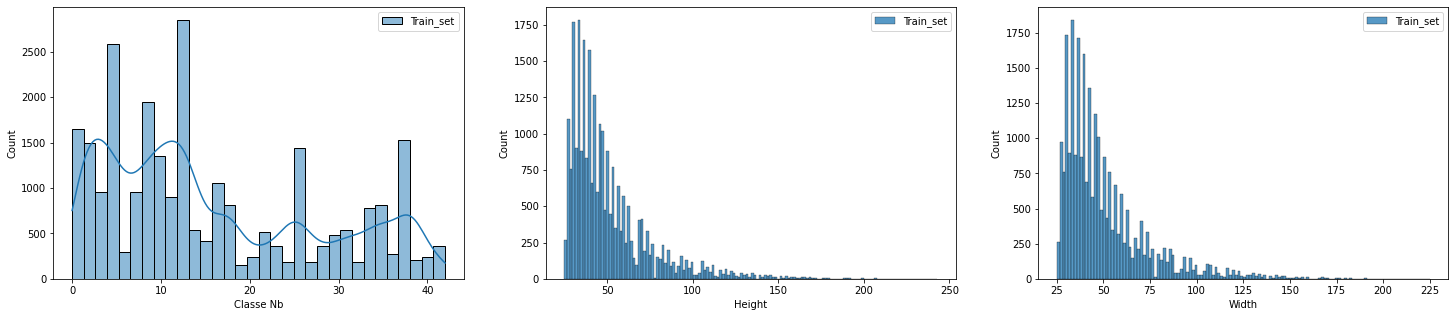

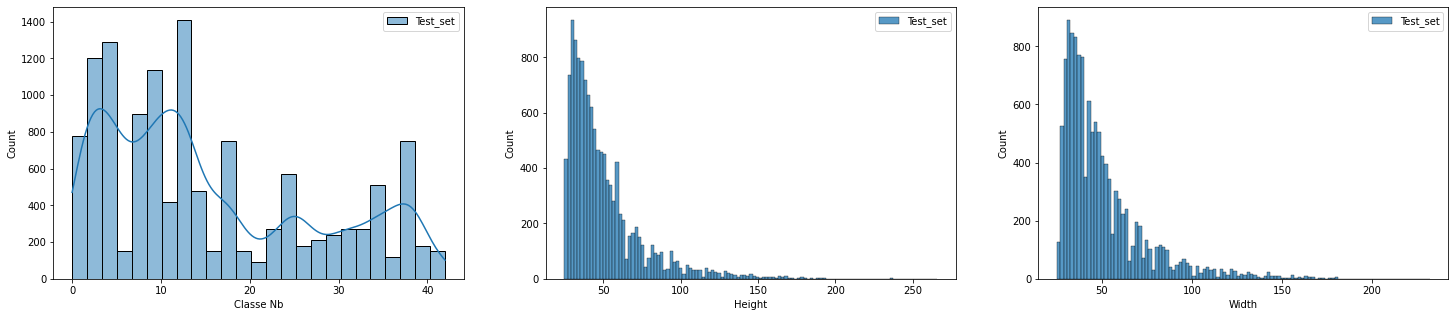

In [38]:
plt.figure(figsize = (25, 5))
plt.subplot(131)
sns.histplot(data=pd_gtsrb_train, x="Classe Nb", label = "Train_set", kde=True)
plt.legend()
plt.subplot(132)
sns.histplot(data=pd_gtsrb_train, x="Height", label = "Train_set")
plt.legend()
plt.subplot(133)
sns.histplot(data=pd_gtsrb_train, x="Width", label = "Train_set")
plt.legend()
plt.show()


plt.figure(figsize = (25, 5))
plt.subplot(131)
sns.histplot(data=pd_gtsrb_test, x="Classe Nb", label = "Test_set", kde=True)
plt.legend()
plt.subplot(132)
sns.histplot(data=pd_gtsrb_test, x="Height", label = "Test_set")
plt.legend()
plt.subplot(133)
sns.histplot(data=pd_gtsrb_test, x="Width", label = "Test_set")
plt.legend()
plt.show()

# Building train validation and test set

Resize all images to the min size

In [39]:
print("Max :\n", np.max(pd_gtsrb_train[['Height',	'Width']]))
print("\nMin :\n",np.min(pd_gtsrb_train[['Height',	'Width']]))

Max :
 Height    243
Width     225
dtype: int64

Min :
 Height    25
Width     25
dtype: int64


In [40]:
np_gtsrb_train = np.array([ls_id_train, ls_images_train, ls_classes_train, ls_height_train, ls_width_train]).T
np_gtsrb_test = np.array([ls_id_test, ls_images_test, ls_classes_test, ls_height_test, ls_width_test]).T

# Min of [heights, widths]
min_hw_train = np.min(np.array(pd_gtsrb_train[['Height',	'Width']]))

features_train = np.zeros((np_gtsrb_train.shape[0], 3*min_hw_train*min_hw_train))
features_test = np.zeros((np_gtsrb_test.shape[0], 3*min_hw_train*min_hw_train))

for i in range (np_gtsrb_train.shape[0]):

  features_train[i,:] = resize(np_gtsrb_train[i,1], (min_hw_train, min_hw_train),
                       anti_aliasing=True).reshape(3*min_hw_train*min_hw_train)

for i in range (np_gtsrb_test.shape[0]):

  features_test[i,:] = resize(np_gtsrb_test[i,1], (min_hw_train, min_hw_train),
                       anti_aliasing=True).reshape(3*min_hw_train*min_hw_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


**Train / test datasets**

In [42]:
target_train = np_gtsrb_train[:,2].astype(float)
target_test = np_gtsrb_test[:,2].astype(float)

#Scale the data train and test
scaler = StandardScaler()
scaler.fit(features_train)
scaled_features_train = scaler.transform(features_train)
scaled_features_test = scaler.transform(features_test)

X_train  = scaled_features_train
y_train = target_train

_, X_test, _, y_test = train_test_split(scaled_features_test,target_test, test_size = 0.3, random_state = 100) #To have the same proportion as for the CNN

# SVM definition

In [77]:
# Building a Support Vector Machine on train data
svc_model = SVC(C= .1, kernel='linear', gamma= 1, max_iter=20, verbose = False, probability=True)
svc_model.fit(X_train, y_train)
 
prediction = svc_model.predict(X_test)
# check the accuracy on the training set
print(svc_model.score(X_train, y_train))
print(svc_model.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


0.4542792792792793
0.3594615993665875


In [78]:
print("Test accuracy :", accuracy_score(y_test, prediction))

Test accuracy : 0.3594615993665875


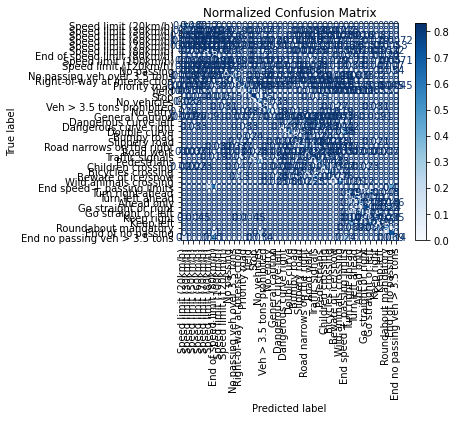

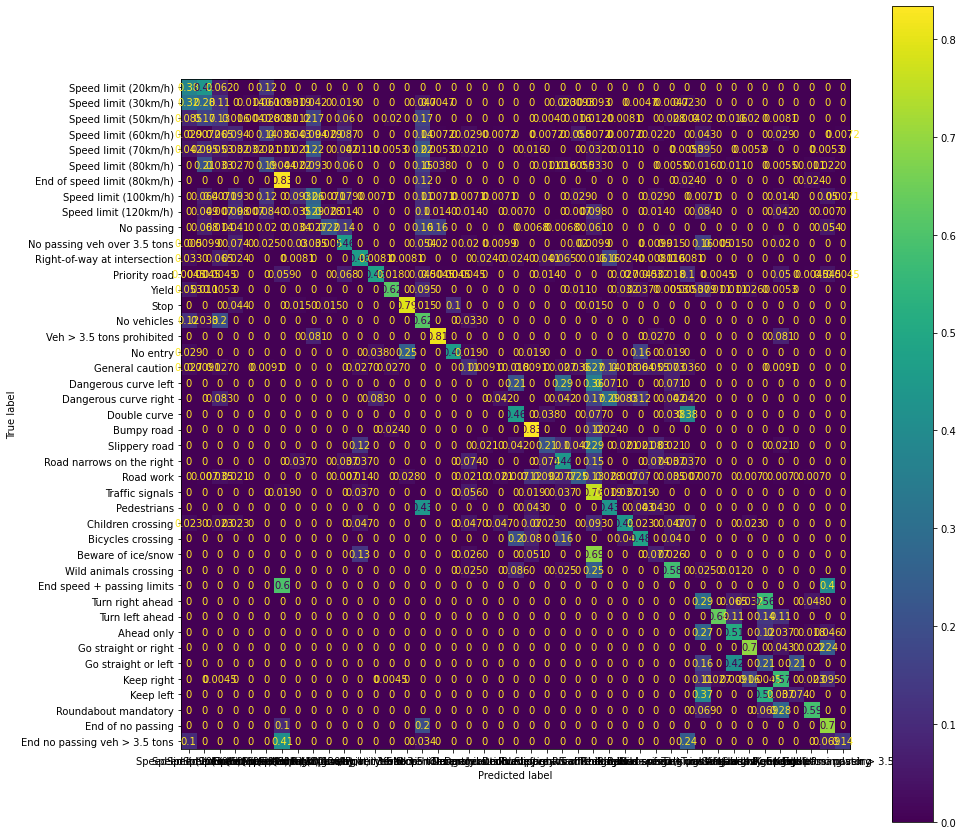

In [79]:
names_classes = np.array(list(classes.items()))[:,1]

disp = ConfusionMatrixDisplay.from_estimator(
        svc_model,
        X_test,
        y_test,
        display_labels= names_classes,
        cmap=plt.cm.Blues,
        normalize="true",
        xticks_rotation = "vertical"
    )
disp.ax_.set_title("Normalized Confusion Matrix")

fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)

plt.show()

# Test

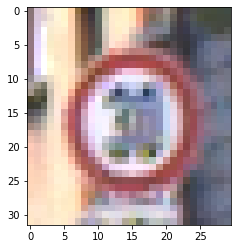

Speed limit (20km/h) = 0.6087266768978425%
Speed limit (30km/h) = 3.3371260500572624%
Speed limit (50km/h) = 5.427705437698108%
Speed limit (60km/h) = 2.314631542832632%
Speed limit (70km/h) = 3.1725474904237863%
Speed limit (80km/h) = 3.8661135983347217%
End of speed limit (80km/h) = 0.8077551201220661%
Speed limit (100km/h) = 1.790932991242862%
Speed limit (120km/h) = 1.601814860777188%
No passing = 2.886388132810868%
No passing veh over 3.5 tons = 2.854126159061928%
Right-of-way at intersection = 2.8030635228782494%
Priority road = 3.6115215931118327%
Yield = 2.1657990964154097%
Stop = 1.9448331646207673%
No vehicles = 2.2073769645342636%
Veh > 3.5 tons prohibited = 1.6274166316555903%
No entry = 2.3096330527816575%
General caution = 2.9491972523910297%
Dangerous curve left = 0.7036906675896357%
Dangerous curve right = 1.0421204067984782%
Double curve = 1.558134178865415%
Bumpy road = 1.6124323906414988%
Slippery road = 2.038582350217127%
Road narrows on the right = 1.49556575078076

In [47]:
img = np.array(np_gtsrb_test[100,1])
plt.imshow(img)
plt.show()
img_resize=resize(img,(min_hw_train,min_hw_train,3))
l=[img_resize.flatten()]
probability= svc_model.predict_proba(l)
for ind,val in enumerate(classes):
    print(f'{classes[val]} = {probability[0][ind]*100}%')
print("The predicted image is : "+classes[svc_model.predict(l)[0]])